# Running TFLite models

## Setup

In [1]:
import tensorflow as tf

import pathlib
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


## Create a basic model of the form y = mx + c

In [2]:
# Create a simple Keras model.
x = [-1, 0, 1, 2, 3, 4]
y = [-3, -1, 1, 3, 5, 7]

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(units=1, input_shape=[1])
])
model.compile(optimizer='sgd', loss='mean_squared_error')
model.fit(x, y, epochs=200, verbose=1)

Epoch 1/200
1/1 [==============================] - 0s 174ms/step - loss: 11.2227
Epoch 2/200
1/1 [==============================] - 0s 3ms/step - loss: 9.0479
Epoch 3/200
1/1 [==============================] - 0s 6ms/step - loss: 7.3323
Epoch 4/200
1/1 [==============================] - 0s 3ms/step - loss: 5.9782
Epoch 5/200
1/1 [==============================] - 0s 3ms/step - loss: 4.9086
Epoch 6/200
1/1 [==============================] - 0s 3ms/step - loss: 4.0628
Epoch 7/200
1/1 [==============================] - 0s 7ms/step - loss: 3.3933
Epoch 8/200
1/1 [==============================] - 0s 3ms/step - loss: 2.8625
Epoch 9/200
1/1 [==============================] - 0s 3ms/step - loss: 2.4410
Epoch 10/200
1/1 [==============================] - 0s 3ms/step - loss: 2.1054
Epoch 11/200
1/1 [==============================] - 0s 3ms/step - loss: 1.8376
Epoch 12/200
1/1 [==============================] - 0s 3ms/step - loss: 1.6232
Epoch 13/200
1/1 [==============================] - 0s 3ms

## Generate a SavedModel

In [3]:
export_dir = 'saved_model/2'
tf.saved_model.save(model, export_dir)


FOR DEVS: If you are overwriting _tracking_metadata in your class, this property has been used to save metadata in the SavedModel. The metadta field will be deprecated soon, so please move the metadata to a different file.
INFO:tensorflow:Assets written to: saved_model/2/assets


## Convert the SavedModel to TFLite

This model pretends to make the tflite model friendly for TPU/NPU execution. This kind of hardware works with 8-bits, so it is needed to quantize the model to use (u)int8 instead of Float32 data types.

This is not the best example for this, and it will be explained later.

To quantize the model, a representative dataset generation is needed. In this case, the model will be feeded with the input data that we want to introduce (values from -1.0 to 4.0), decimal numbers after all.

In [18]:
def representative_dataset_gen():
    raw_test_data = []
    i=np.float32(-1.0)
    while i < 4.0:
        i+=0.01
        #yield [i.astype(np.float32)]
        raw_test_data.append(i)

    for data in raw_test_data:
        yield [data.astype(np.float32)]

This code is exactly as the other notebook, but has an aditional line: _converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]_

This means the model will be fully quantized, while the input and output of the model will still be Float32. This line requires a function called _representative_dataset_gen()_.

In [19]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_saved_model(export_dir)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.representative_dataset = representative_dataset_gen
tflite_model = converter.convert()

We want a different output, so the name of the model has been changed.

In [20]:
tflite_model_file = pathlib.Path('model_edge.tflite')
tflite_model_file.write_bytes(tflite_model)

1232

## Initialize the TFLite interpreter to try it out

In [21]:
# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
# Test the TensorFlow Lite model on random input data.
input_shape = input_details[0]['shape']
inputs, outputs = [], []
for _ in range(100):
  input_data = np.array(np.random.random_sample(input_shape), dtype=np.float32)
  interpreter.set_tensor(input_details[0]['index'], input_data)

  interpreter.invoke()
  tflite_results = interpreter.get_tensor(output_details[0]['index'])

  # Test the TensorFlow model on random input data.
  tf_results = model(tf.constant(input_data))
  output_data = np.array(tf_results)
  
  inputs.append(input_data[0][0])
  outputs.append(output_data[0][0])

## Visualize the model

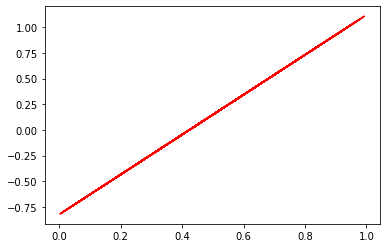

In [23]:
plt.plot(inputs, outputs, 'r')
plt.show()